# Samudra

This notebook will walk you through how to construct the model, load the weights, build the dataset, and use the model to generate a rollout.

## Imports

In [1]:
import sys
sys.path.append("../samudra/")

In [2]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from huggingface_hub import hf_hub_download, snapshot_download

## Configs

We now configure the backends and torch states, including setting the seeds for the RNGs.

In [3]:
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

Using device: NVIDIA A100-SXM4-40GB


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#### Experiment Constants

In [5]:
# Experiment inputs and outputs
DEPTH_LEVELS = ['2_5',
 '10_0',
 '22_5',
 '40_0',
 '65_0',
 '105_0',
 '165_0',
 '250_0',
 '375_0',
 '550_0',
 '775_0',
 '1050_0',
 '1400_0',
 '1850_0',
 '2400_0',
 '3100_0',
 '4000_0',
 '5000_0',
 '6000_0']

INPT_VARS = {
    "3D_thermo_dynamic_all": [
        k + str(j)
        for k in ["uo_lev_", "vo_lev_", "thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"],
    "3D_thermo_all": [
        k + str(j)
        for k in ["thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"]
}
EXTRA_VARS = {
    "3D_all_hfds_anom": ["tauuo", "tauvo", "hfds", "hfds_anomalies"]
}
OUT_VARS = {
    "3D_thermo_dynamic_all": [
        k + str(j)
        for k in ["uo_lev_", "vo_lev_", "thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"],
    "3D_thermo_all": [
        k + str(j)
        for k in ["thetao_lev_", "so_lev_"]
        for j in DEPTH_LEVELS
    ]
    + ["zos"]
}
VARS = {
    "3D_thermo_dynamic_all": ['uo', 'vo', 'thetao', 'so', 'zos'],
    "3D_thermo_all": ['thetao', 'so', 'zos'],
}
MODEL_PATHS = {
    "3D_thermo_dynamic_all": "samudra_thermo_dynamic_seed1.pt",
    "3D_thermo_all": "samudra_thermo_seed1.pt",
}


### Choose the model!

Set exp_num_in to "3D_thermo_all" or "3D_thermo_dynamic_all" corresponding to thermo or the thermo+dynamic model referenced in the paper.

In [6]:
exp_num_in = "3D_thermo_dynamic_all" # "3D_thermo_all" or "3D_thermo_dynamic_all"
exp_num_extra = "3D_all_hfds_anom"
exp_num_out = exp_num_in

model_path = MODEL_PATHS[exp_num_out]

### Data Configs

We will follow the paper's configuration to choose the data's configuration

In [7]:
hist = 1
N_samples = 2850 # Used for train
N_val = 50 # Used for validation
N_test = 600 # Used for testing


In [8]:
inputs_str = INPT_VARS[exp_num_in]
extra_in_str = EXTRA_VARS[exp_num_extra]
outputs_str = OUT_VARS[exp_num_out]
var_ls = VARS[exp_num_out]

levels = len(DEPTH_LEVELS)

N_atm = len(extra_in_str)  # Number of atmosphere variables
N_in = len(inputs_str)
N_extra = N_atm  # Number of atmosphere variables
N_out = len(outputs_str)

num_in = int((hist + 1) * N_in + N_extra)
num_out = int((hist + 1) * len(outputs_str))

print("Number of inputs: ", num_in)
print("Number of outputs: ", num_out) 

# Getting start and end indices of train and test
s_train = hist
e_train = s_train + N_samples
e_test = e_train + N_val  

Number of inputs:  158
Number of outputs:  154



## Data 
The data is available from 1975 to the 2022, at 5-day temporal resolution. The variables in the data is arranged in the following format:


```
thetao_lev_2_5
thetao_lev_10_0
thetao_lev_22_5
...
thetao_lev_6000_0

so_lev_2_5
so_lev_10_0
so_lev_22_5
...
so_lev_6000_0

uo_lev_2_5
uo_lev_10_0
uo_lev_22_5
...
uo_lev_6000_0

vo_lev_2_5
vo_lev_10_0
vo_lev_22_5
...
vo_lev_6000_0

zos

hfds
hfds_anomalies
tauuo
tauvo
```



In [9]:
import xarray as xr

Here, we must take a choice between downloading the data locally (generally the fastest method of generating rollout) or streaming the data from a remote source. 

#### Choice 1: Downloading data locally (Preferred)
Save the data locally! Storage required ~ 12GB

In [10]:
from pathlib import Path

# Replace these local zarr paths if required
data_mean_file = "./data_mean.zarr"
data_std_file = "./data_std.zarr"
data_file = "./data.zarr"

if not Path(data_mean_file).exists():
    data_mean = xr.open_dataset("https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4_means", engine='zarr', chunks={})
    data_mean.to_zarr(data_mean_file, mode="w")
    
data_mean = xr.open_zarr("./data_mean.zarr")

if not Path(data_std_file).exists():
    data_std = xr.open_dataset("https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4_stds", engine='zarr', chunks={})
    data_std.to_zarr(data_std_file, mode="w")
data_std = xr.open_zarr(data_std_file)

if not Path(data_file).exists():
    data = xr.open_dataset("https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4", engine='zarr', chunks={})
    data = data.isel(time=slice(e_test, e_test+hist+1+N_test)) # We only require the data in the test period
    data.to_zarr(data_file, mode="w")
data = xr.open_zarr(data_file)
data

<xarray.Dataset>
Dimensions:            (y: 180, x: 360, lev: 19, time: 602, y_b: 181, x_b: 361)
Coordinates:
    areacello          (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    dz                 (lev) int64 dask.array<chunksize=(19,), meta=np.ndarray>
    lat                (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    lat_b              (y_b, x_b) float64 dask.array<chunksize=(91, 361), meta=np.ndarray>
  * lev                (lev) float64 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
    lon                (y, x) float64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    lon_b              (y_b, x_b) float64 dask.array<chunksize=(91, 361), meta=np.ndarray>
    ocean_fraction     (lev, y, x) float64 dask.array<chunksize=(19, 180, 360), meta=np.ndarray>
  * time               (time) object 2014-09-30 12:00:00 ... 2022-12-24 12:00:00
    wetmask            (lev, y, x) bool dask.array<chunksize=(10, 90, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * y                  (y) float64 -89.24 -88.25 -87.25 ... 87.25 88.25 89.24
Dimensions without coordinates: y_b, x_b
Data variables: (12/81)
    hfds               (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    hfds_anomalies     (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_1050_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_105_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_10_0        (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_lev_1400_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    ...                 ...
    vo_lev_5000_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_550_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_6000_0      (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_65_0        (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    vo_lev_775_0       (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    zos                (time, y, x) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    m2lines/ocean-emulators_git_hash:  https://github.com/m2lines/ocean_emula...
    regrid_method:                     conservative

#### Choice 2: Streaming data
Run this cell to stream the data from a remote source. Run this cell if storage is a constraint (slower rollout generation)

In [11]:
# data_mean = xr.open_dataset("https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4_stds", engine='zarr', chunks={})
# data_std = xr.open_dataset("https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4_means", engine='zarr', chunks={})
# data = xr.open_dataset("https://nyu1.osn.mghpcc.org/m2lines-pubs/Samudra/OM4", engine='zarr', chunks={})
# data = data.isel(time=slice(e_test, e_test+N_test)) # We only require the data in the test period
# data

### Dataloader
The dataloader requires the actual data along with precomputed means and standard deviations for each variable. The dataloader will normalize the data using the means and standard deviations.

In [12]:
# We require the wet mask to pass to the data loader
from utils import extract_wet
wet_zarr = data.wetmask
wet = extract_wet(wet_zarr, outputs_str, hist)
print("Wet resolution:", wet.shape)

Wet resolution: torch.Size([154, 180, 360])


In [13]:
from data_loaders import Test

test_data = Test(
    data,
    inputs_str,
    extra_in_str,
    outputs_str,
    wet,
    data_mean,
    data_std,
    N_test,
    hist,
    0,
    long_rollout=True,
    device="cuda",
)

Long rollout will begin with input and produce output from time index 0 and 2 respectively


/pscratch/sd/s/suryad/conda_envs/samudra/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


## Build Model
We are now ready to build the mdoel.

In [14]:
from model import Samudra

# num_in and num_out depends on the input/output variables [thermo / thermo+dynamic].
model = Samudra(n_out=num_out, ch_width=[num_in]+[200,250,300,400], wet=wet.to(device), hist=hist)

### Load weights

In [15]:
weights_path = Path(model_path)
hf_hub_download(
    repo_id="M2LInES/Samudra",
    filename=weights_path.name,
    local_dir=".",
)    

model.load_state_dict(torch.load(weights_path, map_location=torch.device(device))["model"])
model = model.to(device)

## Rollout

In [16]:
from model import generate_model_rollout

You will notice the rollout starts from index '2' as we are using the initial states at indices '0' and '1' as input.

In [17]:
%%time
model_pred, _ = generate_model_rollout(
            N_test,
            test_data,
            model,
            hist,
            N_out,
            N_extra,
            initial_input=None, 
        )

Out:  [[2 3]] Out:  [[4 5]] Out:  [[6 7]] Out:  [[8 9]] Out:  [[10 11]] Out:  [[12 13]] Out:  [[14 15]] Out:  [[16 17]] Out:  [[18 19]] Out:  [[20 21]] Out:  [[22 23]] Out:  [[24 25]] Out:  [[26 27]] Out:  [[28 29]] Out:  [[30 31]] Out:  [[32 33]] Out:  [[34 35]] Out:  [[36 37]] Out:  [[38 39]] Out:  [[40 41]] Out:  [[42 43]] Out:  [[44 45]] Out:  [[46 47]] Out:  [[48 49]] Out:  [[50 51]] Out:  [[52 53]] Out:  [[54 55]] Out:  [[56 57]] Out:  [[58 59]] Out:  [[60 61]] Out:  [[62 63]] Out:  [[64 65]] Out:  [[66 67]] Out:  [[68 69]] Out:  [[70 71]] Out:  [[72 73]] Out:  [[74 75]] Out:  [[76 77]] Out:  [[78 79]] Out:  [[80 81]] Out:  [[82 83]] Out:  [[84 85]] Out:  [[86 87]] Out:  [[88 89]] Out:  [[90 91]] Out:  [[92 93]] Out:  [[94 95]] Out:  [[96 97]] Out:  [[98 99]] Out:  [[100 101]] Out:  [[102 103]] Out:  [[104 105]] Out:  [[106 107]] Out:  [[108 109]] Out:  [[110 111]] Out:  [[112 113]] Out:  [[114 115]] Out:  [[116 117]] Out:  [[118 119]] Out:  [[120 121]] Out:  [[122 123]] Out:  [[

#### Convert the prediction and ground truth data to the correct format useful for plotting and comparison

In [18]:
from utils import post_processor, convert_train_data
ds_prediction = xr.DataArray(
            data=model_pred,
            dims=["time", "x", "y", "var"]
        )
ds_prediction = ds_prediction.to_dataset(name="predictions")
ds_groundtruth = data.isel(time=slice(hist+1,hist+1+N_test))
ds_prediction = post_processor(ds_prediction, ds_groundtruth, var_ls)
ds_groundtruth = convert_train_data(ds_groundtruth)

## Example Plot

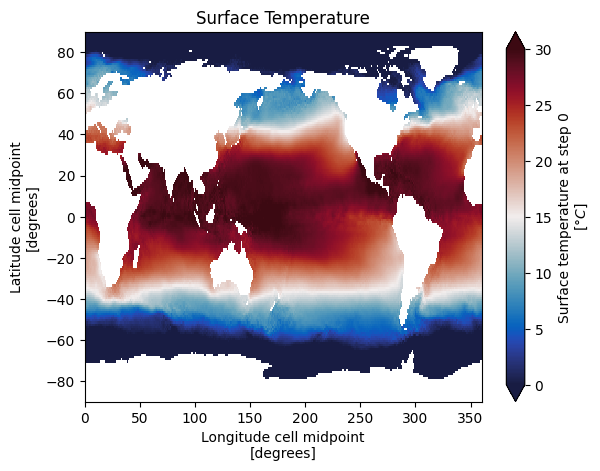

In [19]:
import matplotlib.pyplot as plt
import cmocean as cm
surface_temp_bias = ds_prediction.thetao.isel(time=0, lev=0)
surface_temp_bias.rename(r"Surface temperature at step 0 [$\degree C$]").plot(vmin=0, vmax=30, cmap=cm.cm.balance)
plt.title("Surface Temperature")
plt.show()

## Save rollout

In [20]:
ds_prediction.to_zarr(exp_num_in + '_prediction.zarr', mode='w')